In [8]:
# Use : conda activate xesmf
# Directory : /Users/alkatiwari/MET_Forcing
# File name : Process_IMERG_Daily.ipynb

'''
A. Takes raw IMERG daily data 
    below operation is performed
    1. masking to land
    2. transposing (x as lat and y as lon)
    3. regridding to GCOOP grid - from 0.1 deg to 0.0625 deg
        uses nearest_s2d method in xesmf 
        https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution 
        comparison between nearest and bilinear performed in the script - Processing_IMERG_regridding_masking.ipynb
        
B. Processes GCOOP for the same extent as IMERG
C. validation by plotting raw and regridded data
D. validation by checking point location
E. Working on MAc in MET_Forcing folder
'''

# Create a separate environment for xesmf and have all the pre requisite libraries installed

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from netCDF4 import Dataset
import xarray as xr
import xesmf as xe
import glob
from pathlib import Path

In [9]:
!which python

/Users/alkatiwari/opt/anaconda3/envs/xesmf/bin/python


## Regridding Function

## Preparing IMERG data at GCOOP resolution and mask for land and extent

## Preparing GCOOP data same extent as IMERG

In [10]:

def run_proc(name):
    '''
    processes raw IMERG data
    Change the source and destination folder for processing different storms
    Keep the mask same
    
    Inputs: source_folder, destination_folder
    '''

    # Define the source and destination folders
    # source_folder = 'Charley/IMERG/renamed/'
    # destination_folder = 'Charley/IMERG/dailydata/'

    source_folder = '%s/IMERG/RawData/renamed/' % name
    destination_folder = '%s/IMERG/Data/dailydata/' % name
    dest = Path(destination_folder)
    if not dest.exists(): dest.mkdir()
 
    ####-----------------------------------------------------------------------------------------####
    #____________ Regridding Function_____________
    # GCOOP data with the same extent as imerg
    # Load the mask dataset with the desired extent and grid resolution
    data_dir_mask = 'GCOOP_May24_IMextent.nc'  # Specify the path to your mask dataset
    ds_mask = xr.open_dataset(data_dir_mask)

    # creating ds_out as function to get lat and lon according to GCOOP extent
    # taking the grid distribution from the reference data
    mask_regrid = xr.Dataset({'lat': (['lat'], ds_mask.lat.values),
                     'lon': (['lon'], ds_mask.lon.values),
                    })

    #____________ Regridding Function_____________
    ####-----------------------------------------------------------------------------------------####

    # List all NetCDF files in the source folder
    file_list = glob.glob(source_folder + "*.nc4")

    # Loop through each file in the source folder
    for file_path in file_list:
        # Open the source dataset
        ds_source = xr.open_dataset(file_path)
    
        regridder = xe.Regridder(ds_source, mask_regrid, 'nearest_s2d')

        # Perform the regridding using the initialized regridder
        ds_mask_IMERG_n = regridder(ds_source)
        ds_out_imerg_n = ds_mask_IMERG_n.precipitationCal.values[0]

        ds_livneh_16 = ds_mask.PRCP.values[0]

        # Making imerg value nan where livneh is nan
        ds_out_imerg_n[np.isnan(ds_livneh_16)] = np.nan
        ds_out_im_n = ds_mask_IMERG_n
        ds_out_im_n['PRCP'] = (('lat', 'lon'), ds_out_imerg_n)

        # Save the regridded and masked data
        output_file = destination_folder + file_path.split('/')[-1]  # Keep the same file name
        ds_out_im_n.to_netcdf(output_file)

        # Close the datasets to release resources
        ds_source.close()
        ds_out_im_n.close()


In [11]:
names = ["Beryl"]
for name in names:
    run_proc(name)

/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/frontend.py:835: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  out = out.rename(self._coord_names)
/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/frontend.py:835: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to crea

In [6]:
names = ["Beryl","Charley","Debby","Fay","Frances","Irma","Jeanne","Michael"]
for name in names:
    run_proc(name)

/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/frontend.py:835: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  out = out.rename(self._coord_names)
/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/frontend.py:835: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  out = out.rename(self._coord_names)
/Users/alkatiwari/opt/anaconda3/envs/xesmf/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn(

## Verification by plotting

Text(0.5, 1.0, 'GCOOP_nearest')

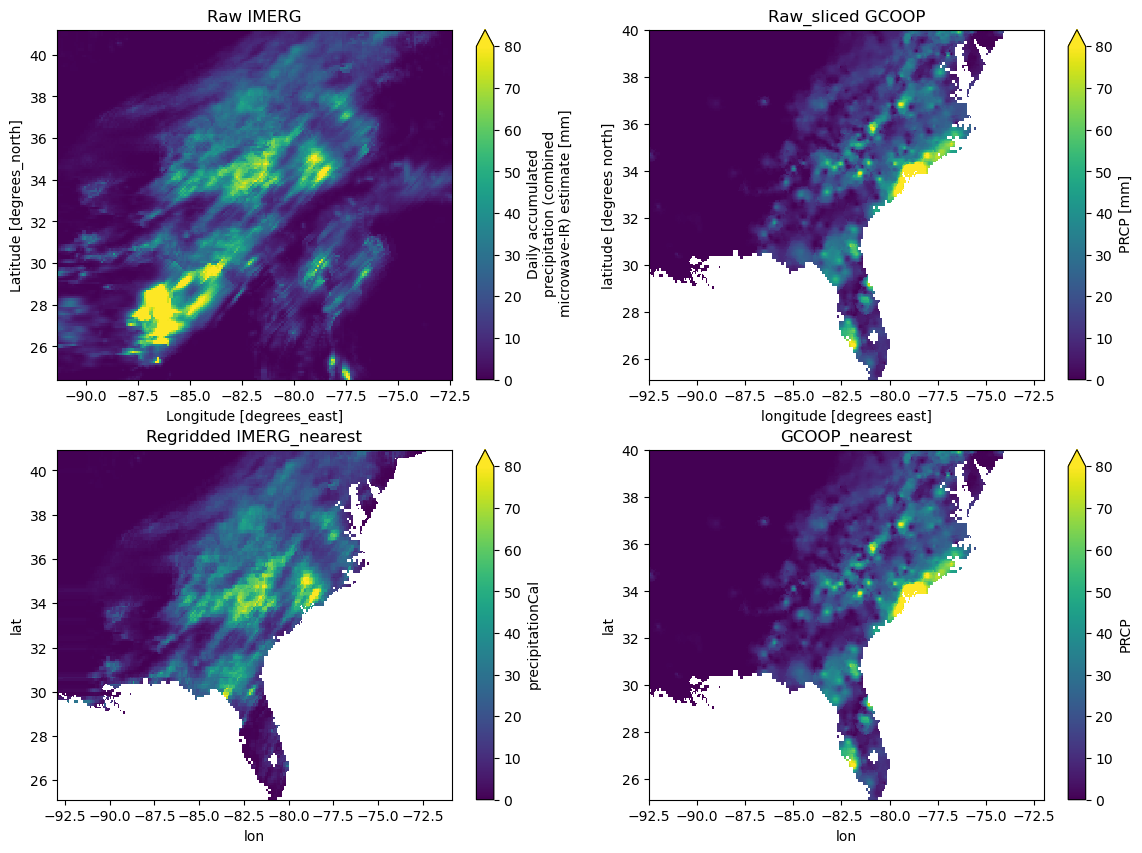

In [6]:
data_dir_IMERG = 'Charley/IMERG/renamed/imerg_20040812.nc4' # raw data imerg 
ds_IMERG_raw = xr.open_dataset(data_dir_IMERG)

#data_dir_IMERG = 'Charley/VIC_imerg/imerg_20040812.nc4' # regridded using bilinear 
#ds_IMERG_VIC = xr.open_dataset(data_dir_IMERG)

data_dir_IMERG = 'Charley/IMERG/dailydata_Aug_9_15/imerg_20040812.nc4' # regridded using nearest s2d 
ds_IMERG_VIC_n = xr.open_dataset(data_dir_IMERG)

data_dir_GCOOP = 'Charley/G-COOP/raw/livneh_20040812.nc' # for regriding we using the extent of imerg 
ds_GCOOP_raw = xr.open_dataset(data_dir_GCOOP)

data_dir_GCOOP = 'Charley/G-COOP/dailydata_Aug_9_15/livneh_20040812.nc' # for regriding we using the extent of imerg 
ds_GCOOP_VIC_n = xr.open_dataset(data_dir_GCOOP)

#data_dir_GCOOP = 'Charley/G-COOP/bilinear/livneh_20040812.nc' # for regriding we using the extent of imerg 
#ds_GCOOP_VIC_b = xr.open_dataset(data_dir_GCOOP)


plt.figure(figsize=[14,10])
plt.subplot(221)
#lat=(25,35) 
#lon=(-84,-75)
ds_IMERG_raw.precipitationCal.T.plot(vmin=0, vmax=80)
#ds_IMERG_VIC.precipitationCal.plot(vmin=0, vmax=80)
plt.title('transposed Raw IMERG')
plt.subplot(223)
ds_IMERG_VIC_n.precipitationCal.plot(vmin=0, vmax=80)
plt.title('Regridded IMERG_nearest')

#ds_GCOOP
plt.subplot(222)
ds_GCOOP_raw.PRCP.sel(lat=slice(25,40)).sel(lon=slice(-92.5, -72)).plot(vmin=0, vmax=80)
plt.title('Raw_sliced GCOOP')


plt.subplot(224)
ds_GCOOP_VIC_n.PRCP.sel(lat=slice(25,40)).sel(lon=slice(-92.5, -72)).plot(vmin=0, vmax=80)
plt.title('GCOOP_nearest')

## Validate using point values

In [7]:
dfg0 = ds_IMERG_raw.sel(lon=-80.59375,lat=26.46875,method='nearest').to_dataframe()
dfg0 = dfg0[~np.isnan(dfg0['precipitationCal'])]
dfg0

,precipitationCal,lat,lon
time,,,
2004-08-12 00:00:00,3.715854,26.450001,-80.549995


In [9]:
dfg0 = ds_IMERG_VIC_n.sel(lon=-80.59375,lat=26.46875,method='nearest').to_dataframe()
dfg0 = dfg0[~np.isnan(dfg0['precipitationCal'])]
dfg0

,precipitationCal,lon,lat,PRCP
time,,,,
2004-08-12 00:00:00,3.715854,-80.59375,26.46875,3.715854


In [8]:
dfg0 = ds_GCOOP_raw.sel(lon=-80.59375,lat=26.46875).to_dataframe()
dfg0 = dfg0[~np.isnan(dfg0['PRCP'])]
dfg0

,lon,lat,PRCP
Time,,,
2004-08-13,-80.59375,26.46875,9.591328


In [10]:
dfg0 = ds_GCOOP_VIC_n.sel(lon=-80.59375,lat=26.46875).to_dataframe()
dfg0 = dfg0[~np.isnan(dfg0['PRCP'])]
dfg0

,PRCP,lon,lat
Time,,,
2004-08-13,9.591328,-80.59375,26.46875


## total accumulation of daily GCOOP data and IMERG

In [15]:
# cdo enssum imerg* imerg_total.nc4

data_dir_IMERG_total = 'Charley/Precip_Total/IMERG_total_Charley_Aug9_14.nc4' # raw data imerg 
IMERG_total_Charley = xr.open_dataset(data_dir_IMERG_total)



In [14]:
pwd

'/Users/alkatiwari/MET_Forcing'

Text(0.5, 1.0, 'Total IMERG_PRCP')

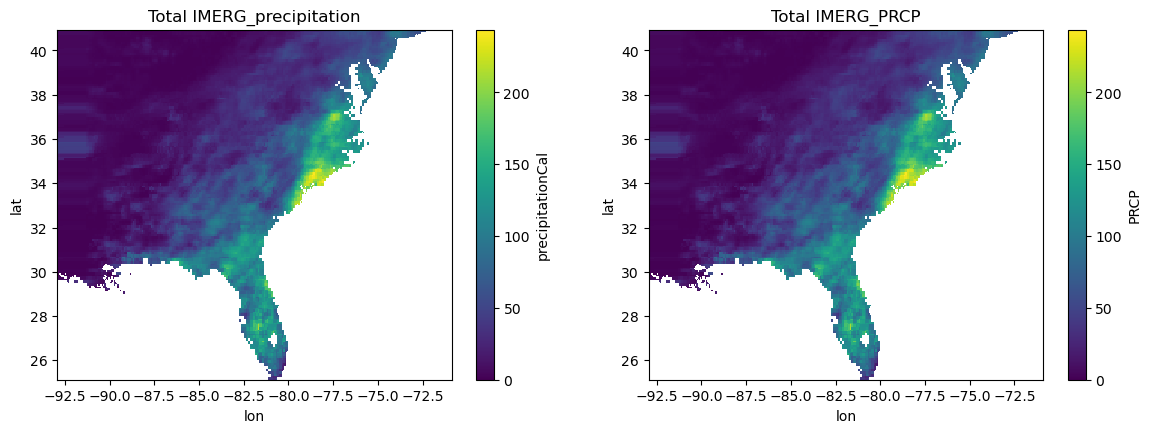

In [17]:

plt.figure(figsize=[14,10])
plt.subplot(221)
#lat=(25,35) 
#lon=(-84,-75)
IMERG_total_Charley.precipitationCal.plot()
#ds_IMERG_VIC.precipitationCal.plot(vmin=0, vmax=80)
plt.title('Total IMERG_precipitation')
plt.subplot(222)
IMERG_total_Charley.PRCP.plot()
plt.title('Total IMERG_PRCP')


In [18]:
dfg0 = IMERG_total_Charley.to_dataframe()

dfg0.describe()

,precipitationCal,PRCP
count,45512.000000,45512.000000
mean,40.327667,40.327667
std,44.339966,44.339966
min,0.000000,0.000000
25%,4.979490,4.979490
50%,25.604790,25.604790
75%,61.238594,61.238594
max,243.683945,243.683945


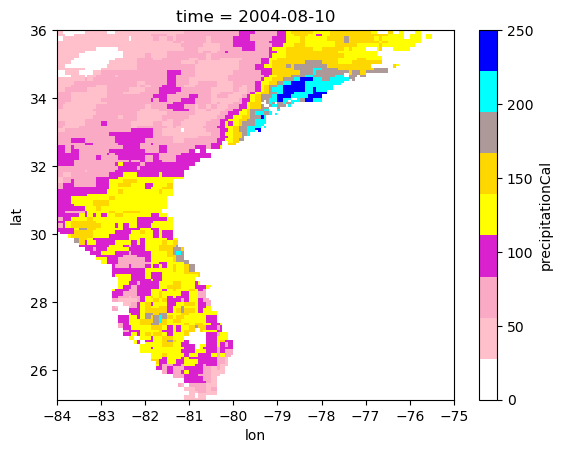

In [30]:
import matplotlib as mpl
normalizer = mpl.colors.Normalize(0,250)

#fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

#cmap = mpl.cm.viridis
clist = ["white","pink","#faaac4","#d921cf","yellow","gold","#ae9999","cyan","blue"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("",clist)
cmap = mpl.colors.ListedColormap(clist)

#bounds = [-1, 2, 5, 7, 12, 15]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

IMERG_total_Charley.precipitationCal.sel(lat=slice(25,36)).sel(lon=slice(-84, -75)).plot(vmin = 0, vmax =250,add_colorbar=True,cmap=cmap)

# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal',
#              label="Discrete intervals with extend='both' keyword")

In [32]:
IMERG_total_Charley.lat


<xarray.DataArray 'lat' (lat: 253)>
array([25.15625, 25.21875, 25.28125, ..., 40.78125, 40.84375, 40.90625])
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 40.72 40.78 40.84 40.91
Attributes:
    axis:     Y